In [21]:
import polars as pl
import pandas as pd
import pyarrow
import cupy as cp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Data Exploration

In [2]:
df = pl.read_csv('flights2018.csv')

In [6]:
df.head()

,ItinID,MktID,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket
i64,i64,i64,i64,i64,str,i64,str,i64,f64,i64,f64,str,f64
0,20181767585,2018176758501,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",672.87
1,20181767586,2018176758601,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",367.68
2,20181767587,2018176758701,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",417.94
3,20181767636,2018176763601,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",247.1
4,20181767637,2018176763701,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",276.35


In [4]:
df.dtypes

[Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 String,
 Int64,
 String,
 Int64,
 Float64,
 Int64,
 Float64,
 String,
 Float64]

In [9]:
rows = len(df)
print('Number of rows: ', rows)

Number of rows:  9534417


In [6]:
print(df.null_count())

shape: (1, 14)
┌─────┬────────┬───────┬────────────┬───┬───────────────┬───────────────────┬────────────────┬────────────────┐
│     ┆ ItinID ┆ MktID ┆ MktCoupons ┆ … ┆ ContiguousUSA ┆ NumTicketsOrdered ┆ AirlineCompany ┆ PricePerTicket │
│ --- ┆ ---    ┆ ---   ┆ ---        ┆   ┆ ---           ┆ ---               ┆ ---            ┆ ---            │
│ u32 ┆ u32    ┆ u32   ┆ u32        ┆   ┆ u32           ┆ u32               ┆ u32            ┆ u32            │
╞═════╪════════╪═══════╪════════════╪═══╪═══════════════╪═══════════════════╪════════════════╪════════════════╡
│ 0   ┆ 0      ┆ 0     ┆ 0          ┆ … ┆ 0             ┆ 0                 ┆ 0              ┆ 0              │
└─────┴────────┴───────┴────────────┴───┴───────────────┴───────────────────┴────────────────┴────────────────┘


In [14]:
unique_carriers = df.select(pl.col("AirlineCompany").unique()).to_series().to_list()
print(unique_carriers)

['B6', 'G4', 'F9', 'VX', 'SY', 'HA', 'AA', 'NK', 'UA', 'DL', 'WN', 'AS']


In [50]:
airline_map = {
    'DL': 'Delta Air Lines',
    'YV': 'Mesa Airlines',
    'MQ': 'Envoy Air',
    'YX': 'Republic Airways',
    'SY': 'Sun Country Airlines',
    'OH': 'PSA Airlines',
    'PT': 'Piedmont Airlines',
    '3M': 'Silver Airways',
    'AA': 'American Airlines',
    'QX': 'Horizon Air',
    'G7': 'GoJet Airlines',
    'MX': 'Breeze Airways (or legacy Mexicana)',
    'B6': 'JetBlue Airways',
    'OO': 'SkyWest Airlines',
    'XP': 'Avelo Airlines (or former Xtra Airways)',
    'ZW': 'Air Wisconsin',
    'UA': 'United Airlines',
    'HA': 'Hawaiian Airlines',
    'F9': 'Frontier Airlines',
    'AS': 'Alaska Airlines',
    'G4': 'Allegiant Air',
    'C5': 'CommutAir',
    'NK': 'Spirit Airlines',
    'WN': 'Southwest Airlines',
    '9E': 'Endeavor Air'
}

In [64]:
!pip uninstall pandas

^C


In [15]:
origins = df.select(pl.col("Origin").unique()).to_series().to_list()
print(origins)

['RST', 'MKG', 'MDT', 'DAB', 'PGD', 'BIL', 'OGS', 'SRQ', 'ACK', 'STC', 'CRW', 'MYR', 'MIA', 'PHX', 'MSY', 'AKN', 'CVG', 'HNL', 'JNU', 'RDM', 'LGB', 'BWI', 'ORH', 'ELM', 'IAG', 'SYR', 'HGR', 'COS', 'GFK', 'CLT', 'DSM', 'GST', 'BHM', 'STX', 'FAI', 'ICT', 'IND', 'SFB', 'YNG', 'HRL', 'ROC', 'SHV', 'TLH', 'GRB', 'MOB', 'GSO', 'OKC', 'OMA', 'IAH', 'CID', 'LIT', 'DTW', 'CDV', 'YAK', 'FCA', 'ELP', 'MKK', 'LIH', 'PBI', 'SCE', 'GNV', 'EVV', 'FAY', 'RDU', 'ORD', 'LBB', 'TOL', 'SPI', 'BDL', 'BTR', 'MRY', 'BLI', 'LAX', 'SPS', 'PNS', 'OTZ', 'ALB', 'PSP', 'SPN', 'OWB', 'ACY', 'ONT', 'LRD', 'GUM', 'USA', 'KTN', 'SLN', 'MCO', 'GJT', 'SCC', 'FWA', 'HSV', 'COU', 'SFO', 'PWM', 'ITO', 'MSN', 'SJC', 'BOS', 'MLI', 'HYA', 'ADK', 'SJU', 'ORF', 'OGG', 'TYS', 'MSO', 'TTN', 'GTF', 'CAE', 'GPT', 'ABI', 'BZN', 'BFL', 'JAC', 'RIC', 'SNA', 'ERI', 'MCI', 'PSG', 'LFT', 'RKS', 'MFR', 'PSC', 'OGD', 'PDX', 'JHM', 'BLV', 'HDN', 'AVL', 'SBA', 'GSP', 'JAX', 'PIT', 'VPS', 'PBG', 'SCK', 'MOT', 'PSE', 'BQN', 'BMI', 'RFD', 'SGU'

In [16]:
dests = df.select(pl.col("Dest").unique()).to_series().to_list()
print(dests)

['SRQ', 'DFW', 'SJU', 'TTN', 'VPS', 'RDM', 'DCA', 'ECP', 'OME', 'MLB', 'KTN', 'OWB', 'KOA', 'BHM', 'EWR', 'ICT', 'MTJ', 'EGE', 'LRD', 'FCA', 'BMI', 'ACY', 'SFB', 'PIT', 'DLG', 'SCK', 'TRI', 'RFD', 'LEX', 'IND', 'OAK', 'ACK', 'SCC', 'FSD', 'PGD', 'AVP', 'SJC', 'YAK', 'ILM', 'RDU', 'GST', 'ITH', 'JNU', 'LIH', 'JAX', 'OKC', 'CAE', 'ORH', 'EVV', 'PWM', 'LIT', 'FAI', 'GTF', 'GUC', 'SWF', 'MHT', 'CHA', 'MSY', 'WRG', 'ISP', 'SHV', 'DAY', 'CRP', 'BQN', 'SAV', 'BWI', 'HNL', 'FAY', 'SPN', 'STS', 'SMF', 'PHL', 'PSG', 'ATL', 'EYW', 'PSP', 'ELP', 'STX', 'MFR', 'STC', 'PNS', 'GPT', 'BTR', 'ANC', 'RNO', 'IDA', 'FAR', 'CDV', 'TOL', 'FAT', 'USA', 'YNG', 'MKG', 'STL', 'CPR', 'IAH', 'CLT', 'BOS', 'SLC', 'PHX', 'PDX', 'BDL', 'MBS', 'PVU', 'GFK', 'BNA', 'MSP', 'LGB', 'GSO', 'ONT', 'PIA', 'MSN', 'MEM', 'LAX', 'ORF', 'TUS', 'SGF', 'DEN', 'SBP', 'RSW', 'MMH', 'TPA', 'LBE', 'DLH', 'GUM', 'IAG', 'BUF', 'HTS', 'SAT', 'CRW', 'BIS', 'AUS', 'BRW', 'SCE', 'RST', 'JAN', 'BKG', 'OTH', 'BOI', 'SNA', 'PPG', 'GSP', 'MCI'

In [12]:
num_df = df.select([col for col in df.columns if df[col].dtype in [pl.Float64, pl.Int64]])

# Convert to NumPy then to CuPy
np_data = num_df.to_numpy()
cp_data = cp.asarray(np_data)

# Normalize the data
cp_data = (cp_data - cp.mean(cp_data, axis=0)) / cp.std(cp_data, axis=0)

# Compute correlation matrix on GPU
corr_matrix = cp.corrcoef(cp_data, rowvar=False)
corr_matrix = cp.asnumpy(corr_matrix)  # Move back to CPU for plotting

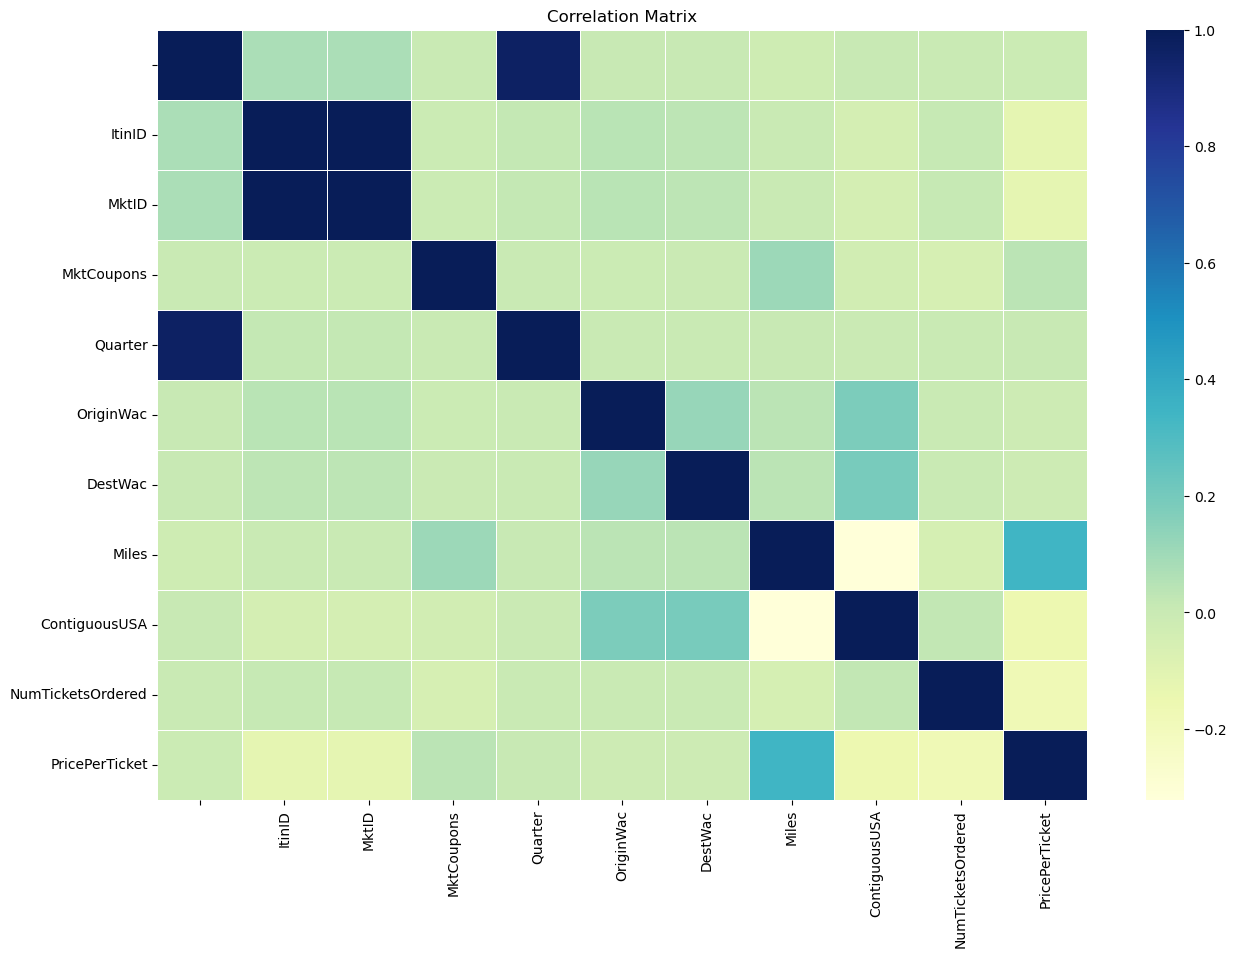

In [14]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            xticklabels=num_df.columns, 
            yticklabels=num_df.columns,
            cmap="YlGnBu", 
            annot=False,
            linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

## Modelling the Data

In [7]:
def rmsle(y_test, y_preds):
    return cp.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(models, X_train, X_test, y_train, y_test):
    model_scores={}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        scores = {
                  'MAE': mean_absolute_error(y_test, preds),
                  'RMSLE': rmsle(y_test, preds),
                  'MSE': mean_squared_error(y_test, preds),
                  'R^2': r2_score(y_test, preds)}
        model_scores[name] = scores
    return model_scores

In [8]:
df.head()

,ItinID,MktID,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany,PricePerTicket
i64,i64,i64,i64,i64,str,i64,str,i64,f64,i64,f64,str,f64
0,20181767585,2018176758501,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",672.87
1,20181767586,2018176758601,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",367.68
2,20181767587,2018176758701,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",417.94
3,20181767636,2018176763601,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",247.1
4,20181767637,2018176763701,1,1,"""PHL""",23,"""LAX""",91,2402.0,2,1.0,"""AA""",276.35


In [9]:
data = pd.read_csv('flights2018.csv')
X = data.drop(['PricePerTicket', 'OriginWac', 'DestWac', 'ContiguousUSA'], axis=1)
X.head()

,Unnamed: 0,ItinID,MktID,MktCoupons,Quarter,Origin,OriginWac,Dest,DestWac,Miles,ContiguousUSA,NumTicketsOrdered,AirlineCompany
0,0,20181767585,2018176758501,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA
1,1,20181767586,2018176758601,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA
2,2,20181767587,2018176758701,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA
3,3,20181767636,2018176763601,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA
4,4,20181767637,2018176763701,1,1,PHL,23,LAX,91,2402.0,2,1.0,AA


In [10]:
y = data['PricePerTicket']
y

0          672.87
1          367.68
2          417.94
3          247.10
4          276.35
            ...  
9534412    310.10
9534413    106.17
9534414    161.19
9534415    170.87
9534416    379.02
Name: PricePerTicket, Length: 9534417, dtype: float64

In [11]:
df.dtypes

[Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 String,
 Int64,
 String,
 Int64,
 Float64,
 Int64,
 Float64,
 String,
 Float64]

In [12]:
worded_features = ['Origin', 'Dest', 'AirlineCompany']
one_hot = OneHotEncoder()
transformer = ColumnTransformer([('one_hot',
                                   one_hot,
                                   worded_features)],
                                   remainder='passthrough')
transformed_X = transformer.fit_transform(X)
transformed_X

<9534417x545 sparse matrix of type '<class 'numpy.float64'>'
	with 123947420 stored elements in Compressed Sparse Row format>

In [22]:
models = {
          'XGBoost': XGBRegressor(),
          'LGB': LGBMRegressor()
}

In [20]:
cp.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.20)

scores = show_scores(models, X_train, X_test, y_train, y_test)
mae_scores={}
for name in scores:
    print(name)
    print('MAE: ', scores[name]['MAE'])
    print('RMSLE: ', scores[name]['RMSLE'])
    print('MSE: ', scores[name]['MSE'])
    print('R^2: ', scores[name]['R^2'])
    print('\n')
    mae_scores[name] = scores[name]['MAE']

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2139
[LightGBM] [Info] Number of data points in the train set: 7627533, number of used features: 500
[LightGBM] [Info] Start training from score 232.462302


C:\Users\dever\Documents\flight-advisor\env\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


XGBoost
MAE:  84.2310451054731
RMSLE:  0.4604966504297507
MSE:  14024.684359135263
R^2:  0.3166525708318051


LGB
MAE:  84.88903205610731
RMSLE:  0.46419710921883545
MSE:  14198.202675421797
R^2:  0.30819795664501515


